In [1]:
import numpy as np
import scipy.linalg as spl
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve,bicgstab,bicg,gmres,cg
from scipy.fftpack import dct,idct,dst,idst
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.interpolate as spi
plt.rcParams['figure.figsize'] = [16, 12]
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
from numba import jit 
from scipy.stats import linregress 

# ------------------2D_POISSON_SOLVERS-----------------------
# ---------------------------------------

# octave tests

# Test Functions

In [11]:
def func(x,y):
    return -5*np.pi**(2)*np.sin(np.pi*x)*np.cos(2*np.pi*y)
def gfunc(x,y):
    return np.sin(np.pi*x)*np.cos(2*np.pi*y)
def func1(x,y):
    return 10*(np.pi**(2))*np.exp(np.sin(2*np.pi*(x+2*y)))*(-2*np.sin(2*np.pi*(x+2*y))+np.cos(4*np.pi*(x+2*y))+1)
def gfunc1(x,y):
    return np.exp(np.sin(2*np.pi*(x+2*y)))
def func2(x,y):
    return -8*(np.pi**(2))*np.cos(2*np.pi*x)*np.cos(2*np.pi*y)
def gfunc2(x,y):
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

#  Helper Functions

In [12]:
# @jit(nopython=True)
def norm2(A):
    return np.linalg.norm(A,2)
# @jit(nopython=True)
def inv(A):
    return np.linalg.inv(A)
# @jit(nopython=True)
def condnp(A):
    return np.linalg.cond(A,2)
# @jit(nopython=True)
def condaj(A):
    return np.linalg.norm(np.linalg.inv(A),2)*np.linalg.norm(A,2)
def solve(A,x):
    return np.linalg.solve(A,x)
def relerr(uapprox,uexact):
    return np.linalg.norm((uapprox-uexact),2)/np.linalg.norm((uexact),2)
def abserr(uapprox,uexact):
    return np.linalg.norm((uapprox-uexact))

# ----------------------------------------

# DENSE GE

In [17]:
def fd2poisson(f,g,a,b,m):
    
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    end1=m+1
    end2=m+2
    idx=np.arange(1,end1)
    idy=np.arange(1,end1)
    
    # function evaluation
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    
    h=(b-a)/(m+1)
    
    # Dense Differentiation Matrices (2D Laplacian)
    z1=np.array([-2,1])
    z2=np.zeros(m-2)
    z=np.block([z1,z2])
    D2=spl.toeplitz(z,z)
    I=np.eye(m)
    D2x=np.kron(D2,I)
    D2y=np.kron(I,D2)
    L=(h**-2)*(D2x+D2y)
    
    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)
 
    #RHS
    f=np.reshape(f,m*m)
    
    #Solving the System
    u=np.linalg.solve(L,f)
    u=np.reshape(u,(m,m))

    return u,X,Y


# SPARSE GE

In [2]:
def fd2poissonsp(f,g,a,b,m):
    
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    h=(b-a)/(m+1)
    
    # Sparse Differentiation Matrices (2D Laplacian)

    l1=[1]*(m-1)
    l0=[-2]*(m)

    D2=sp.diags( [l1,l0,l1], [-1,0,1], format='csr')
    
    I=sp.eye(m)
    D2y=sp.kron(I,D2)
    D2x=sp.kron(D2,I)
    L=(h**-2)*(D2x+D2y)
    
    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)

    f=np.reshape(f,m*m)
    
    #Solving the System
    u=spsolve(L,f)
    u=np.reshape(u,(m,m))

    return u,X,Y

## Krylov Methods (CG,GMRES,BiCGStab,BiCG) 

In [22]:
def poicg(f,g,a,b,m):
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    h=(b-a)/(m+1)

    # Sparse Differentiation Matrices (2D Laplacian)

    l1=[1]*(m-1)
    l0=[-2]*(m)

    D2=sp.diags( [l1,l0,l1], [-1,0,1], format='csr')

    I=sp.eye(m)
    D2y=sp.kron(I,D2)
    D2x=sp.kron(D2,I)
    L=(h**-2)*(D2x+D2y)

    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)
    
    #RHS
    f=np.reshape(f,m*m)
    
    #krylov methods
    ucg,es3=cg(L,f,tol=1e-10)
    
    #reshaping into grid
    
    ucg=ucg.reshape(m,m)
    
    
    return ucg,X,Y

In [23]:
def poibicg(f,g,a,b,m):
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    h=(b-a)/(m+1)

    # Sparse Differentiation Matrices (2D Laplacian)

    l1=[1]*(m-1)
    l0=[-2]*(m)

    D2=sp.diags( [l1,l0,l1], [-1,0,1], format='csr')

    I=sp.eye(m)
    D2y=sp.kron(I,D2)
    D2x=sp.kron(D2,I)
    L=(h**-2)*(D2x+D2y)

    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)
    
    #RHS
    f=np.reshape(f,m*m)
    
    #krylov methods
    ubicg,es2=bicg(L,f,tol=1e-16)
    
    #reshaping into grid
    ubicg=ubicg.reshape(m,m)
    
    return ubicg,X,Y

In [24]:
def poigmres(f,g,a,b,m):
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    h=(b-a)/(m+1)

    # Sparse Differentiation Matrices (2D Laplacian)

    l1=[1]*(m-1)
    l0=[-2]*(m)

    D2=sp.diags( [l1,l0,l1], [-1,0,1], format='csr')

    I=sp.eye(m)
    D2y=sp.kron(I,D2)
    D2x=sp.kron(D2,I)
    L=(h**-2)*(D2x+D2y)

    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)
    
    #RHS
    f=np.reshape(f,m*m)
    
    #krylov methods
    ugmres,es4=gmres(L,f,tol=1e-12)
    
    
    #reshaping into grid
    ugmres=ugmres.reshape(m,m)
    
    return ugmres,X,Y

In [25]:
def poibicgstab(f,g,a,b,m):
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    f=f(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    g=g(X,Y)
    h=(b-a)/(m+1)

    # Sparse Differentiation Matrices (2D Laplacian)

    l1=[1]*(m-1)
    l0=[-2]*(m)

    D2=sp.diags( [l1,l0,l1], [-1,0,1], format='csr')

    I=sp.eye(m)
    D2y=sp.kron(I,D2)
    D2x=sp.kron(D2,I)
    L=(h**-2)*(D2x+D2y)

    #Boundary Conditions
    ubs=g[0,1:m+1]
    ubn=g[m+1,1:m+1]
    ube=g[1:m+1,m+1]
    ubw=g[1:m+1,0]

    f[:,0]-=ubw*(h**-2)
    f[:,m-1]-=ube*(h**-2)
    f[0,:m]-=ubs*(h**-2)
    f[m-1,:m]-=ubn*(h**-2)
    
    #RHS
    f=np.reshape(f,m*m)
    
    #krylov methods
    ubicgs,es1=bicgstab(L,f,tol=1e-16)

    #reshaping into grid
    ubicgs=ubicgs.reshape(m,m)

    return ubicgs,X,Y

# Jacobi

In [26]:
@jit(nopython=True)
def jacobiloops(u,f,m,h):
#     err=0.0
    for jj in range(1,m+1):
            for kk in range(1,m+1):
                u[jj,kk] = (0.25)*(u[jj-1,kk]+u[jj+1,kk]+u[jj,kk-1]+\
                                       u[jj,kk+1]-(h**2)*f[jj,kk]) 
                
    res=np.zeros((m+1,m+1))
    for jj in range(1,m):
            for kk in range(1,m):
                res[jj,kk]= np.abs(f[jj,kk] - (-4*u[jj,kk]+u[jj-1,kk] \
                          +u[jj+1,kk]+u[jj,kk-1]+u[jj,kk+1])/(h**2))
                
    return u,res

In [27]:
def jacobipoisson(f,g,a,b,m):
    h=(b-a)/(m+1)

    #Mesh construction
    x = np.linspace(a,b,m+2)
    y = x
    X,Y = np.meshgrid(x,y)
    u = np.zeros((m+2,m+2))
    
    end1 = m+1
    end2 = m+2
    idx = np.arange(1,end2)
    idy = np.arange(1,end2)
    
    #Boundary Conditions 
    ubs = g(X[0,0:end2],Y[0,0:end2])
    ubn = g(X[end1,0:end2],Y[end1,0:end2])
    ube = g(X[idy,end1],Y[idy,end1])
    ubw = g(X[idy,0],Y[idy,0])
    
    u[0,:end2] = ubs
    u[end1,:end2] = ubn
    u[idx,end1] = ube
    u[idx,0] = ubw
    
    #RHS
    f = f(X,Y)
    
    # residual control and iterations
    tol = 1e-8
    nrmf = norm2(f.flatten())
    maxiter=10000
    itr=0
    temp=np.zeros((m+2,m+2))
    for i in range(0,maxiter):
        u,res=jacobiloops(u,f,m,h)
        err=norm2(res.flatten())
        itr+=1
        if err<tol*nrmf:
            break;
    return u[1:m+1,1:m+1],X,Y

# SOR 

In [2]:
@jit(nopython=True)
def sorloops(u,f,m,omega,h):
    err=0.0
    for jj in range(1,m+1):
            for kk in range(1,m+1):
                u[jj,kk] = (0.25*omega)*(u[jj-1,kk]+u[jj+1,kk]+u[jj,kk-1]+\
                                       u[jj,kk+1]-(h**2)*f[jj,kk]) + (1.0-omega)*u[jj,kk]
    res=np.zeros((m+1,m+1))
    for jj in range(1,m):
            for kk in range(1,m):
                res[jj,kk]= np.abs(f[jj,kk] - (-4*u[jj,kk]+u[jj-1,kk] \
                          +u[jj+1,kk]+u[jj,kk-1]+u[jj,kk+1])/(h**2))
    
    return u,res

In [3]:
def poissonsor(f,g,a,b,m):
    h=(b-a)/(m+1)
    omegaopt = 2.0/(1.0+np.sin(np.pi*h))

    #Mesh construction
    x = np.linspace(a,b,m+2)
    y = x
    X,Y = np.meshgrid(x,y)
    u = np.zeros((m+2,m+2))
    
    end1 = m+1
    end2 = m+2
    idx = np.arange(1,end2)
    idy = np.arange(1,end2)
    
    #Boundary Conditions 
    ubs = g(X[0,0:end2],Y[0,0:end2])
    ubn = g(X[end1,0:end2],Y[end1,0:end2])
    ube = g(X[idy,end1],Y[idy,end1])
    ubw = g(X[idy,0],Y[idy,0])
    
    u[0,:end2] = ubs
    u[end1,:end2] = ubn
    u[idx,end1] = ube
    u[idx,0] = ubw
    
    #RHS
    f = f(X,Y)
    
    # residual control and iterations
    tol = 1e-8
    nrmf = norm2(f.flatten())
    maxiter=10000
    itr=0
    for i in range(maxiter):
        u,res=sorloops(u,f,m,omegaopt,h)
        itr+=1
        err=norm2(res)
        if err <= tol*nrmf:
            break;
    return u,X,Y

# MultiGrid V-Cycle (Work In Progress)

In [30]:
@jit(nopython=True)
def dampedJacobi(u,f,h,k,numSmooths):
    omega = 4.0/5.0
    n = 2.0**k 
    fjac = (h**2)*f
    for i in range(0,numSmooths):
        for jj in range(1,n):
            for kk in range(1,n):
                u[jj,kk] = (0.25*omega)*(u[jj-1,kk]+u[jj+1,kk]+u[jj,kk-1]+\
                                       u[jj,kk+1]-fjac[jj,kk]) + (1.0-omega)*u[jj,kk]
                
    return u

In [31]:
# %%writefile residual.py
@jit(nopython=True)
def residual(r,f,u,h):
    for jj in range(1,len(u)-1):
            for kk in range(1,len(u)-1):
                r[jj,kk] = f[jj,kk] - (-4*u[jj,kk]+u[jj-1,kk] \
                           +u[jj+1,kk]+u[jj,kk-1]+u[jj,kk+1])/(h**2)
    return r

In [32]:
def vcycle(u,f,h,k):
    numSmooths =20
    n = 2**k
#     print(n)
    n=int(n)
    n2 = n/2
    n2=int(n2)

    if k == 1:
        u[1,1] = 0.25*(u[0,1]+u[2,1]+u[1,0]+u[1,2]-(h**2)*f[1,1])
        return u
    else:
        #Smooth
        u = dampedJacobi(u,f,h,k,numSmooths)
        
        # Compute residual
        r=residual(np.zeros((n,n)),f,u,h)
        
        # Restrict the residual to the coarser grid using full-weighting
        ii = np.arange(2,n-1,2,dtype=np.int16)
        f2 = np.zeros((n2+1,n2+1))
        f2[1:n2,1:n2] = (r[ii-1,ii]+r[ii+1,ii]+r[ii,ii-1]+r[ii,ii+1]+4*r[ii,ii])/8
        
        #-----------------------------------------------------------
        u2 = vcycle(np.zeros((n2+1,n2+1)),f2,2.0*h,k-1)
        #-----------------------------------------------------------
        if len(u2)==2:
#         print(np.shape(u2))
            u2=u2[0]
            r=u2[1]
#             print(r)
        #Interpolate (prolongate) the correction to the finer grid
        ut = np.zeros((n+1,n+1))
        
        #red/black ordering update and smooth
        ut[0:n+1:2,0:n+1:2] = u2
        ut[1:n:2,0:n+1:2] = 0.5*(u2[0:n2,:]+u2[1:n2+1,:]);
        ut[:,1:n+1:2] = 0.5*(ut[:,0:n-1:2]+ut[:,2:n+1:2]);
        u = dampedJacobi(u+ut,f,h,k,numSmooths)
        
        # Compute residual
        r=residual(np.zeros((n+1,n+1)),f,u,h)

        return u,r

In [16]:
def fd2poissonmg(f,g,a,b,m):
    k = round(np.log2(m+1));
    if abs(np.log2(m+1)-k) > 100*1e-16:
        print('fd2poissonMg:power2','m+1 must be a power of 2')
    h = (b-a)/(2**k)   # Mesh spacing

    #Mesh construction
    x=np.linspace(a,b,m+2)
    y=x
    X,Y=np.meshgrid(x,y)
    u = np.zeros((m+2,m+2))

    end1=m+1
    end2=m+2
    idx=np.arange(1,end2)
    idy=np.arange(1,end2)

    #Boundary Conditions 
    ubs=g(X[0,0:end2],Y[0,0:end2])
    ubn=g(X[end1,0:end2],Y[end1,0:end2])
    ube=g(X[idy,end1],Y[idy,end1])
    ubw=g(X[idy,0],Y[idy,0])

    u[0,:end2]=ubs
    u[end1,:end2]=ubn
    u[idx,end1]=ube
    u[idx,0]=ubw

    # RHS u_xx+u_yy =f
    f=f(X,Y)

    tol = 1e-8
    r = np.ones((m+1,m+1))*np.inf
    nrmf = norm2(f.flatten())
    itr=0
    while norm2(r.flatten()) > tol*nrmf:
        u,r= vcycle(u,f,h,k)
        itr+=1
    return u,X,Y

In [117]:
# %%timeit
a,b=0,1
k=5
m=(2**k)-1
# print(m)
# start=time.time()
%time umg,X,Y=fd2poissonmg(func1,gfunc1,a,b,m)
# end=time.time()
# end-start

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 13.9 ms


Converged in 37 v-cycle iterations for m = 15 
Converged in 140 v-cycle iterations for m = 31 
Converged in 514 v-cycle iterations for m = 63 
Converged in 1640 v-cycle iterations for m = 127 
Converged in 7929 v-cycle iterations for m = 255 


Text(0.5, 1.0, 'Multigrid')

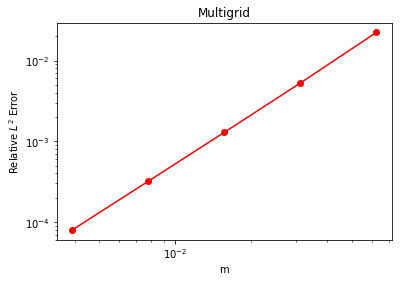

In [48]:
a,b=0,1
n=10
err2=[]
m2=[]
h2=[]
p2=[]
for k in range(4,n-1):
    m=(2**k)-1
#     print(k,"\n")
    umg,X,Y=fd2poissonmg(func1,gfunc1,a,b,m)
    umg=umg[1:m+1,1:m+1]
    h=(b-a)/(m+1)
    uexact2=gfunc1(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
    err=relerr(umg,uexact2)
#     m2.append(m)
    h2.append(h)
    err2.append(err)
plt.loglog(h2,err2,"ro-")
plt.xlabel("m")
plt.ylabel("Relative $L^{2}$ Error")
plt.title("Multigrid")


In [36]:
for i in range(0,len(err2)-1):
        p=np.log(err2[i]/err2[i+1])/np.log(h2[i]/h2[i+1])
        p2.append(p)
        pm=np.mean(p2)
        print(h2[i],"&",err2[i],"&",p2[i],"\\\\")


0.0625 & 0.022300514255348028 & 2.083874444902634 \\
0.03125 & 0.005260247310517183 & 2.030918285192405 \\
0.015625 & 0.0012871786877848214 & 2.013310991928357 \\


Text(0.5, 0, 'u(x,y)')

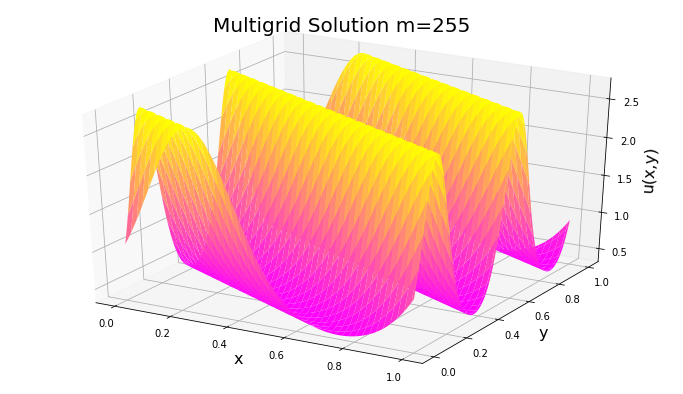

In [54]:
fig=plt.figure(figsize=(12,7))
ax=plt.gca(projection='3d')

uexact=gfunc1(X,Y)
X2=X[1:m+1,1:m+1]
Y2=Y[1:m+1,1:m+1]

# ax.plot_surface(X,Y,umg,cmap='summer')
# ax.plot_surface(X2,Y2,umg-uexact2,cmap='summer')
# plt.title('Multigrid Error m=%g'%m, fontsize=20)

ax.plot_surface(X2,Y2,umg,cmap='spring')
plt.title('Multigrid Solution m=%g'%m, fontsize=20)

ax.set_xlabel('$X$', fontsize=16)
ax.set_ylabel('$X$', fontsize=16)
ax.set_zlabel('$X$', fontsize=16)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')

# POISSON_DRIVER 
## Check speed ,convergence, or visualize solutions/error

In [18]:
a=0;b=1
solver_converge(poissonsor,func,gfunc,a,b)

<function poissonsor at 0x7f95ed226bf8>
else


([0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125],
 [0.058725341006768635,
  0.013289718879487858,
  0.0031915267128820274,
  0.0007837857963642123,
  0.00019431576607168533,
  4.8383184695336106e-05,
  1.2071992302049903e-05])

/usr/local/lib/python3.7/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


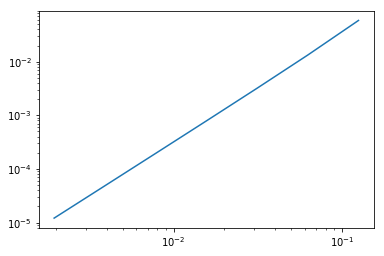

In [22]:
hs=[0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]
errs=[0.058725341006768635,0.013289718879487858,0.0031915267128820274,0.0007837857963642123,\
0.00019431576607168533,\
4.8383184695336106e-05,\
1.2071992302049903e-05]
plt.loglog(hs,errs)

In [25]:
p2=[]
for i in range(len(errs)):
        p=np.log(errs[i]/errs[i-1])/np.log(hs[i]/hs[i-1])
        p2.append(p)
        pm=np.mean(p2)
        print(p2[i])

2.0413506132271433
2.1436725984412646
2.0579919590478473
2.0257153891027055
2.012056468217911
2.00582532153329
2.002841943019841


In [10]:
import time

In [5]:
solvers=[fd2poisson,fd2poissonsp,jacobipoisson,poissonsor,poicg,poibicg
         ,poibicgstab,poigmres,fd2poissonmg]

NameError: name 'fd2poisson' is not defined

In [4]:
solname=['fd2poisson'
    ,'fd2poissonsp'
    ,'jacobipoisson'
    ,'poissonsor'
    ,'poicg'
    ,'poibicg'
    ,'poibicgstab'
    ,'poigmres'
    ,'fd2poissonmg']

In [14]:
def solver_clock(solver,f,g,a,b):
    times=[];ms=[];
    print(solver)
    if solver=='fd2poisson':
        print("if")
        for k in range(3,7):
            m=(2**k)-1
            start=time.time()
            solver(f,g,a,b,m);
            end=time.time()
            times.append(end-start)
    else:
        print("else")
        if solver==fd2poissonmg:
            return "Not working just yet"
        else:
            for k in range(3,10):
                m=(2**k)-1
                start=time.time()
                solver(f,g,a,b,m);
                end=time.time()
                times.append(end-start)
    return times

In [7]:
def solver_errplot(solver,solvername,f,g,a,b,k):
    print(solver)
    m=(2**k)-1
    u,X,Y=solver(f,g,a,b,m)

    fig=plt.figure(figsize=(12,7))
    
    ax=plt.gca(projection='3d')
    X2=X[1:m+1,1:m+1]
    Y2=Y[1:m+1,1:m+1]
    ue=g(X2,Y2)
    if u.shape==ue.shape and u.shape==X.shape:
        print(ue.shape,u.shape)
        ax.plot_surface(X,Y,abs(u-ue),cmap='hsv')
        plt.title(solvername+' Absolute Error m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('$|u(x,y)-u_{exact}(x,y)|$')
        
    elif u.shape!=ue.shape:
        ue=g(X2,Y2)
        u=u[1:m+1,1:m+1]
        print(ue.shape,u.shape)
        ax.plot_surface(X2,Y2,abs(u-ue),cmap='hsv')
        plt.title(solvername+' Absolute Error m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('$|u(x,y)-u_{exact}(x,y)|$')
        
    elif u.shape==ue.shape:
        print(ue.shape,u.shape)
#         u=u[1:m+1,1:m+1]
        ax.plot_surface(X2,Y2,abs(u-ue),cmap='hsv')
        plt.title(solvername+' Absolute Error m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('$|u(x,y)-u_{exact}(x,y)|$')
    else:
        print(ue.shape,u.shape)
        u=u[X2,Y2]
        ax.plot_surface(X2,Y2,abs(u-ue),cmap='hsv')
        plt.title(solvername+' Absolute Error m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('$|u(x,y)-u_{exact}(x,y)|$')

    return;

In [8]:
def solver_plot(solver,solvername,f,g,a,b,k):
    print(solver)
    m=(2**k)-1
    u,X,Y=solver(f,g,a,b,m)

    fig=plt.figure(figsize=(12,7))
    
    ax=plt.gca(projection='3d')
    X2=X[1:m+1,1:m+1]
    Y2=Y[1:m+1,1:m+1]
    ue=g(X2,Y2)
    if u.shape==X.shape:
        ax.plot_surface(X,Y,u,cmap='hsv')
        plt.title(solvername+' Solution m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u(x,y)')
        
    elif u.shape==X2.shape:
        ax.plot_surface(X2,Y2,u,cmap='hsv')
        plt.title(solvername+' Solution m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u(x,y)')
    else:
        u=u[1:m+1,1:m+1]
        ax.plot_surface(X2,Y2,u,cmap='hsv')
        plt.title(solvername+' Solution m=%g'%m, fontsize=20)
        ax.set_xlabel('$X$', fontsize=16)
        ax.set_ylabel('$X$', fontsize=16)
        ax.set_zlabel('$X$', fontsize=16)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u(x,y)')

    return;

In [9]:
def solver_converge(solver,f,g,a,b):
    hs=[];errs=[];
    print(solver)
    if solver==fd2poisson:
        print("if")
        for k in range(3,7):
            m=(2**k)-1
            u,X,Y=solver(f,g,a,b,m)
            u=u
            h=(b-a)/(m+1)
            ue=g(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
            err=relerr(u,ue)
            errs.append(err)
            hs.append(h)
    else:
        print("else")
        if solver==fd2poissonmg:
            print("Not working just yet")
            return;
        else:
            for k in range(3,10):
                m=(2**k)-1
                h=(b-a)/(m+1)
                u,X,Y=solver(f,g,a,b,m)
                ue=g(X[1:m+1,1:m+1],Y[1:m+1,1:m+1])
                if u.shape!=ue.shape:
                    u=u[1:m+1,1:m+1]
                err=relerr(u,ue)
                errs.append(err)
                hs.append(h)
    return hs,errs

# The cells below run tests

In [40]:
# a=0;b=1
# h_all=[];err_all=[]
# for solver in solvers:
#     hdat,errdat=solver_converge(solver,func1,gfunc1,a,b)
#     h_all.append(hdat)
#     err_all.append(errdat)

In [39]:
# a=0;b=1
# ts=[]
# for solver in solvers:
#     t=solver_clock(solver,func1,gfunc1,a,b)
#     ts.append(t)

In [37]:
# a=0;b=1;k=6
# for i in range(len(solvers)):
#     solver_plot(solvers[i],solname[i],func1,gfunc1,a,b,k)

In [38]:
# a=0;b=1;k=6
# for i in range(len(solvers)):
#     solver_plot(solvers[i],solname[i],func1,gfunc1,a,b,k)

In [41]:
# tmgoct=[0.0108039,
# 0.015636,
# 0.0208349,
# 0.033855,
# 0.0849221,
# 0.378152,
# 1.79009]
# ts[-1]=tmgoct

In [42]:
# ms=[2**i -1 for i in range(3,10)]
# ms
# for i in range(len(ts)):
#     plt.plot(ms[:len(ts[i])],ts[i],'o-',label=(solname[i]))
#     plt.xlabel('m')
#     plt.ylabel('time (secs)')
#     plt.legend()
# plt.savefig('poiclock.png')